<a href="https://colab.research.google.com/github/paulo037/text2sql/blob/main/finetuning/FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet accelerate peft bitsandbytes transformers trl  faiss-gpu langchain_community
# flash-attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
# load the required packages.
import torch
from datasets import load_dataset, Dataset
from peft import LoraConfig, AutoPeftModelForCausalLM
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, AutoConfig
from trl import SFTTrainer
import os
import transformers
import numpy as np
import pandas as pd
from peft import LoraConfig, AutoPeftModelForCausalLM, PeftModel
import sqlparse
import bitsandbytes as bnb
import os
from huggingface_hub import hf_hub_download
from huggingface_hub import HfFileSystem

In [3]:
#transformers.logging.set_verbosity_info()

In [ ]:
from google.colab import userdata
READ_TOKEN = userdata.get('hf_read')
WRITE_TOKEN = userdata.get('hf_write')

In [4]:
!rm -r checkpoint-*
!rm  -r /home/studio-lab-user/.cache/huggingface/hub/models--paulo037-*

rm: cannot remove 'checkpoint-*': No such file or directory
rm: cannot remove '/home/studio-lab-user/.cache/huggingface/hub/models--paulo037-*': No such file or directory


In [5]:
adapter_model_id = "NESPED-GEN/Phi-3-sql-spider"
prev_checkpoint= "checkpoint-200"

In [6]:
#!huggingface-cli login

In [7]:
dataset_id="NESPED-GEN/spider"

### Load Data


In [8]:
dataset = load_dataset(dataset_id, split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/7944 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1867 [00:00<?, ? examples/s]

In [9]:
df = dataset.to_pandas()

# Load Base Model

In [10]:
def download_checkpoint(adapter_model_id, checkpoint):

  if(checkpoint not in os.listdir('./') ):
    os.mkdir(checkpoint)

  fs = HfFileSystem()
  for file in fs.ls(f'{adapter_model_id}/{checkpoint}', detail=False):

    file_name = file.split(checkpoint)[-1]

    hf_hub_download(repo_id=adapter_model_id, filename=(f'{checkpoint}{file_name}'), local_dir='./')

In [11]:

model_name = "microsoft/Phi-3-mini-128k-instruct"
out_name = f"NESPED-GEN/Phi-3-sql-spider"

seed=14
new_tokens = {'additional_special_tokens': ['[SQL]','[/SQL]', '[QUESTION]','[/QUESTION]']}

if (prev_checkpoint == None):
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, device_map='auto')
    tokenizer.add_special_tokens(new_tokens)
else:
    download_checkpoint(adapter_model_id, prev_checkpoint)
    tokenizer = AutoTokenizer.from_pretrained(prev_checkpoint, trust_remote_code=True, device_map='auto')

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=False,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True,
    # attn_implementation="flash_attention_2"
)

model.config.pretraining_tp = 1
model.resize_token_embeddings(len(tokenizer))

checkpoint-200/README.md:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

checkpoint-200/adapter_config.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

checkpoint-200/added_tokens.json:   0%|          | 0.00/377 [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/1.61G [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

checkpoint-200/special_tokens_map.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

checkpoint-200/tokenizer.json:   0%|          | 0.00/1.85M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

checkpoint-200/tokenizer_config.json:   0%|          | 0.00/4.83k [00:00<?, ?B/s]

checkpoint-200/trainer_state.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/3.35k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

Embedding(32015, 3072)

#### Chat Template

In [12]:
tokenizer.chat_template = """
{% if messages[0]['role'] == 'system' %}
    {% set loop_messages = messages[1:] %}
    {% set system_message = messages[0]['content'] %}
{% else %}
    {% set loop_messages = messages %}
    {% set system_message = 'You are an SQL expert tasked with answering questions about an SQLite database./n/Your responses must always consist of valid SQL code and only that.' %}
{% endif %}
{{ bos_token }}{{ '# <|system|>/n/' + system_message + '/n//n/' }}
{% if messages|selectattr("role", "equalto", "example")|list %}
    Below are some examples of question and their corresponding SQL queries:/n//n/
{% else %}
    /n/
{% endif %}
{% for message in loop_messages %}
    {% if message['role'] == 'example' %}
        {{ message['content'] }}/n//n/
    {% elif message['role'] == 'schema' %}
        # <|schema|>/n/The query will run on a database with the following schema:/n/{{ message['content'] }}/n//n/
    {% elif message['role'] == 'user' %}
        # <|user|>/n/[QUESTION]{{ message['content'] }}[/QUESTION]/n//n/
    {% elif message['role'] == 'assistant' %}
        # <|assistant|>/n/[SQL]{{ message['content'] }}[/SQL]
    {% endif %}
{% endfor %}
{% if add_generation_prompt %}
    # <|assistant|>/n/[SQL]
{% endif %}
""".replace("\n","").replace("  ", "").replace("/n/", "\n")

In [13]:
def to_sql(query):
  return sqlparse.format(query, reindent=True, keyword_case='upper')

def apply_template(row, tokenizer=tokenizer):
  example = row['sql_example_80']
  if (bool(example)):
    example = example.split('[SQL]')
    example[1] = to_sql(example[1].split("[/SQL]")[0]) + ";[/SQL]"
    example = "[SQL]".join(example)
    messages = [{"role": "example", "content": example } ]
  else:
    messages = []
  messages += [
    {"role": "schema", "content": row['schema']},
    {"role": "user", "content": row['question_en']},
    {"role": "assistant", "content": to_sql(row['query']) + ';'},
  ]

  row['text'] = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)

  return row

In [14]:
df = df.apply(apply_template, axis=1)

In [15]:
print(df['text'][6])

<s># <|system|>
You are an SQL expert tasked with answering questions about an SQLite database.
Your responses must always consist of valid SQL code and only that.

Below are some examples of question and their corresponding SQL queries:

[QUESTION]What are the total number of credits offered by each department?[/QUESTION]
[SQL]SELECT sum(T1.crs_credit),
       T1.dept_code
FROM course AS T1
JOIN CLASS AS T2 ON T1.crs_code = T2.crs_code
GROUP BY T1.dept_code;[/SQL]

# <|schema|>
The query will run on a database with the following schema:

CREATE TABLE advisor (
	"s_ID" VARCHAR(5), 
	"i_ID" VARCHAR(5), 
	PRIMARY KEY ("s_ID"), 
	FOREIGN KEY("i_ID") REFERENCES instructor ("ID"), 
	FOREIGN KEY("s_ID") REFERENCES student ("ID")
)


CREATE TABLE classroom (
	building VARCHAR(15), 
	room_number VARCHAR(7), 
	capacity NUMERIC(4, 0), 
	PRIMARY KEY (building, room_number)
)


CREATE TABLE course (
	course_id VARCHAR(8), 
	title VARCHAR(50), 
	dept_name VARCHAR(20), 
	credits NUMERIC(2, 0), 
	PRI

In [16]:
_df = pd.DataFrame(columns=['text'])
_df['text'] = df['text']
df = Dataset.from_pandas(_df)
train_dataset = df.train_test_split(test_size=0.01, shuffle=False, seed=42)["train"]
valid_dataset = df.train_test_split(test_size=0.01, shuffle=False, seed=42)["test"]

In [17]:
n_tokens = list(map(lambda x: len(tokenizer.encode(x)), df['text']))

In [18]:
max_token = max(n_tokens)
sum(np.array(n_tokens) > 1248)

1330

<Axes: ylabel='Count'>

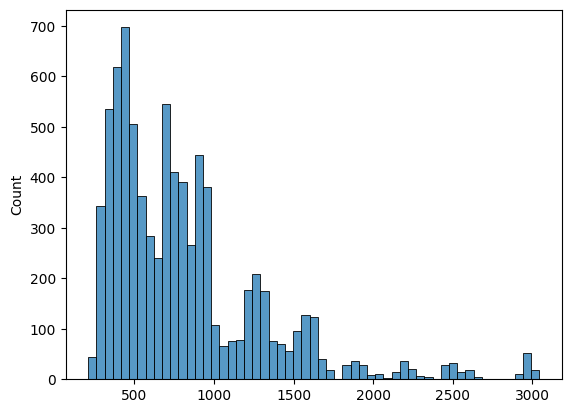

In [19]:
import seaborn as sns
sns.histplot(n_tokens)

### Finetuning

In [20]:
def find_all_linear_names(model, new_tokens=True):
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, bnb.nn.Linear4bit):
            names = name.split(".")
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if(new_tokens):
      lora_module_names.add("lm_head")
    return list(lora_module_names)

In [21]:
modules = find_all_linear_names(model)
print(f"Found {len(modules)} modules to quantize: {modules}")

Found 5 modules to quantize: ['down_proj', 'lm_head', 'o_proj', 'gate_up_proj', 'qkv_proj']


In [22]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
    modules_to_save=["embed_tokens"],
)

steps=100
strategy="steps"
training_arguments = TrainingArguments(
    output_dir=out_name,

    save_steps=steps,
    logging_steps=steps,
    eval_steps=steps,
    evaluation_strategy=strategy,
    save_strategy=strategy,
    logging_strategy=strategy,

    num_train_epochs=50,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    bf16=False,

    optim="paged_adamw_32bit",
    learning_rate=2e-4,
    weight_decay=0.001,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="linear",
    seed= seed,

    save_total_limit=1,
    report_to="all",
    push_to_hub=True,
    hub_strategy="all_checkpoints",
    hub_token=WRITE_TOKEN,
    hub_model_id=out_name,
)

In [23]:
torch.cuda.empty_cache()

In [ ]:
trainer = SFTTrainer(
    model= model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=2048,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=True,
)

if(prev_checkpoint != None):
  trainer.train(prev_checkpoint)
else:
  trainer.train()

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
